# Understanding Leaspy's Data Containers: `Data` and `Dataset`

In `leaspy`, transforming raw data (like a CSV) into a model-ready format involves two key classes: `Data` and `Dataset`. Understanding their distinct roles is crucial for having full control of your analysis.

---

## 1. The `Data` Class: The User Interface

The `Data` class is your **primary tool** for loading, organizing, and inspecting data. It acts as a flexible, patient-centric container that bridges the gap between raw spreadsheets and the model.

## Key Features & Methods

### **Loading Data**
Use the factory method to load from a pandas DataFrame. Notice that there is a slight difference when you work with joint models.

In [7]:
import os
import pandas as pd
import leaspy
from leaspy.io.data import Data

leaspy_root = os.path.dirname(leaspy.__file__)
data_path = os.path.join(leaspy_root, "datasets/data/simulated_data_for_joint.csv")
df = pd.read_csv(data_path, dtype={"ID": str}, sep=";")

data = Data.from_dataframe(df) 							# <-
# For joint models (longitudinal + time-to-event):
data_joint = Data.from_dataframe(df, data_type='joint')	# <-
print(df.head(3))

    ID    TIME  EVENT_TIME  EVENT_BOOL       Y0    Y1   Y2   Y3
0  116  78.461        85.5           1  0.44444  0.04  0.0  0.0
1  116  78.936        85.5           1  0.60000  0.00  0.0  0.2
2  116  79.482        85.5           1  0.39267  0.04  0.0  0.2


### **Inspection**: 
Access data naturally by patient ID or index. This is made thanks to the iterators handdling inside `Data`, it also allows you to iterate using for loops. So you can:
*   select data usint the brackets (`data['116']`)
*   check some attributes (`data.n_individuals`) 
*   convert the whole dataset or some individuals back into a dataframe object (`data[['116']].to_dataframe()`)
*   iterate into each individual (`for individual in data:`)
*   generate an iterator (`for i, individual in enumerate(data):`)

In [16]:
patient_data = data['116']  # Get a specific individual
n_patients = data.n_individuals    # Get total count
print(f"Number of patients: {n_patients}")
print(f"patient data (observations shape): {patient_data.observations.shape}")
print(f"patient data (dataframe):\n{data[['116']].to_dataframe()}")
print("\nIterating over first 3 patients:")
for individual in data:
    if len(individual.timepoints) == 10: break
    print(f" - Patient {individual.idx}: {len(individual.timepoints)} visits")
for i, individual in enumerate(data):
    if i >= 3: break # Stop after 3 iterations using the index 'i'
    print(f"Patient ID: {individual.idx}")

Number of patients: 17
patient data (observations shape): (9, 6)
patient data (dataframe):
    ID    TIME  EVENT_TIME  EVENT_BOOL       Y0    Y1   Y2   Y3
0  116  78.461        85.5         1.0  0.44444  0.04  0.0  0.0
1  116  78.936        85.5         1.0  0.60000  0.00  0.0  0.2
2  116  79.482        85.5         1.0  0.39267  0.04  0.0  0.2
3  116  79.939        85.5         1.0  0.58511  0.00  0.0  0.0
4  116  80.491        85.5         1.0  0.57044  0.00  0.0  0.0
5  116  81.455        85.5         1.0  0.55556  0.20  0.1  0.2
6  116  82.491        85.5         1.0  0.71844  0.20  0.1  0.6
7  116  83.463        85.5         1.0  0.71111  0.32  0.2  0.6
8  116  84.439        85.5         1.0  0.91111  0.52  0.6  1.0

Iterating over first 3 patients:
 - Patient 116: 9 visits
 - Patient 142: 11 visits
 - Patient 169: 7 visits
Patient ID: 116
Patient ID: 142
Patient ID: 169


### **Managing Cofactors**
Easily attach patient characteristics (e.g., genetics, demographics). It is used to group populations when using `plotter.plot_distribution`, so plotter can color different cofactors. Lets generate a dataset and its parameters to show how it works.

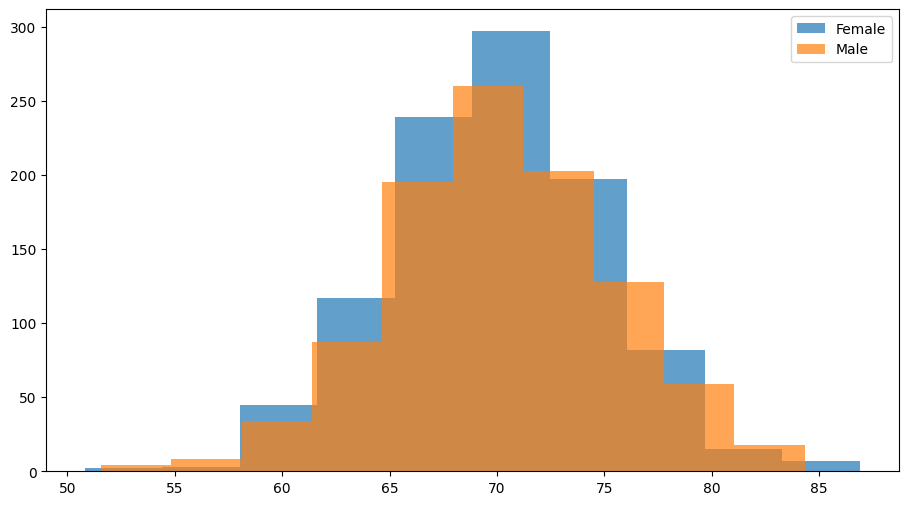

In [50]:
import numpy as np
import torch
from leaspy.io.logs.visualization import Plotter
from leaspy.io.outputs import Result

n_individuals = 2000
patient_ids = [str(i) for i in range(n_individuals)]

df_longitudinal = pd.DataFrame({'ID': np.repeat(patient_ids, 3), 'TIME': np.tile([60, 70, 80], n_individuals), 'Y0': np.random.rand(n_individuals * 3)})
data = Data.from_dataframe(df_longitudinal)

df_cofactors = pd.DataFrame({'gender': np.random.choice(['Male', 'Female'], size=n_individuals)}, index=patient_ids)
df_cofactors.index.name = 'ID'
data.load_cofactors(df_cofactors, cofactors=['gender'])

individual_parameters = {'tau': torch.tensor(np.random.normal(70, 5, (n_individuals, 1))), 'xi': torch.tensor(np.random.normal(0, 0.5, (n_individuals, 1)))}
result_obj = Result(data, individual_parameters)

Plotter().plot_distribution(result_obj, parameter='tau', cofactor='gender')

It is important to note that attaching external data to the class through `data.load_cofactors` is different from loading cofactors inside the model using `factory_kws`:

| Feature | **Covariates** (via `factory_kws`) | **Cofactors** (via `load_cofactors`) |
| :--- | :--- | :--- |
| **Purpose** | Used **inside the model** to modulate parameters (e.g., in `CovariateLogisticModel`). | Used for **analysis/metadata** (e.g., plotting, stratification) but ignored by the model's math. |
| **Loading** | Loaded **during** `Data` creation. | Loaded **after** `Data` creation. |
| **Storage** | Stored as a `numpy.ndarray` in `individual.covariates`. | Stored as a `dict` in `individual.cofactors`. |
| **Constraints** | Must be **integers**, constant per individual, and have no missing values. | Can be any type (strings, floats, etc.). |


### **Best Practice:**
Always create a `Data` object first. It validates your input and handles irregularities (missing visits, different timelines) gracefully.

---

## 2. The `Dataset` Class: The Internal Engine

The `Dataset` class is the **high-performance numerical engine**. It converts the flexible `Data` object into rigid PyTorch Tensors optimized for mathematical computation.

### What it does
*   **Tensorization**: Converts all values to PyTorch tensors.
*   **Padding**: Standardizes patient timelines by padding them to the maximum number of visits (creating a rectangular data block).
*   **Masking**: Creates a binary mask to distinguish real data from padding.

### When to use it explicitly?
You rarely need to instantiate `Dataset` yourself. However, it is useful for **optimization**:
1.  **Memory Efficiency**: For massive datasets, convert `Data` $\to$ `Dataset` and delete the original `Data`/`DataFrame` to free up RAM.
2.  **Performance**: If you are running multiple models on the same data, creating a `Dataset` once prevents `leaspy` from repeating the conversion process for every `fit()` call.

---

## 3. Workflow & Best Practices

### The Standard Workflow
The most common and recommended workflow is straightforward:

```
[CSV / DataFrame]  ->  Data.from_dataframe()  ->  [Data Object]  ->  model.fit(data)
```

Inside `model.fit(data)`, Leaspy automatically converts your `Data` object into a `Dataset` for computation.

### Guidelines for `model.fit()`

| Input Type | Verdict | Reason |
| :--- | :--- | :--- |
| **`Data` Object** | ✅ **Recommended** | **Safe & Standard.** Handles all model types (including Joint models) correctly. Easy to inspect before fitting. |
| **`Dataset` Object** | ⚡ **Optimization** | **Fast.** Use for heavy datasets or repeated experiments to skip internal conversion steps. |
| **`pd.DataFrame`** | ❌ **Avoid** | **Risky.** Fails for complex models (e.g., `JointModel`) that require specific loading parameters. Leads to inconsistent code. |